# Task 1, single mode analysis.

We have defined an script bellow where We have set the mode analysis for an strip waveguide analyzing width sweep with respect to the modes.

We analyze 2 different thickness length, for 220 nm and 300nm, this first script decribe the analysis for 220 nm

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
from tidy3d.plugins import waveguide
from tidy3d.plugins.mode import ModeSolver

# --- 1. Material Definitions ---
# Using fixed indices for 1550nm for simplicity

wavelength =  1.55                              # Central wavelength
wv_points = 3                                   # number of wavelength wv_points
wdth_points = 80                                # number of width wv_points
num_modes = 2                                   # max number of modes to look up
n_si = 3.475
n_sio2 = 1.458

sweep_wavelength = np.linspace(1.5,1.6,wv_points)  # Sweep on wavelengths
sweep_freq = td.C_0 / sweep_wavelength          # Sweep on Frequencies
sweep_width = np.linspace(0.220,1,wdth_points)

mat_si = td.material_library["cSi"]["Li1993_293K"] # Material trace permitivity model for crystaline Silicon
mat_sio2 = td.material_library["SiO2"]["Horiba"]   # Material trace permitivity model for crystaline Silica

def extract_nonzero_columns(padded_array):
    """
    Extracts the non-zero contiguous part of each column in a
    zero-padded 2D array.

    Parameters
    ----------
    padded_array : np.ndarray
        2D array where each column is zero-padded but contains
        a contiguous block of non-zero values.

    Returns
    -------
    list_of_arrays : list of np.ndarray
        List containing 1D arrays ready for plotting.
    """

    padded_array = np.asarray(padded_array)

    if padded_array.ndim != 2:
        raise ValueError("Input must be a 2D array.")

    extracted = []

    for col in padded_array.T:  # iterate over columns

        nonzero_indices = np.nonzero(col)[0]

        if len(nonzero_indices) == 0:
            extracted.append(np.array([]))
        else:
            start = nonzero_indices[0]
            end = nonzero_indices[-1] + 1
            extracted.append(col[start:end])

    return extracted


def count_nonzero_per_row(padded_array):
    """
    Counts the number of non-zero elements in each row
    of a 2D array.

    Parameters
    ----------
    padded_array : np.ndarray
        2D array possibly containing zero padding.

    Returns
    -------
    counts : np.ndarray
        1D array containing the number of non-zero
        elements in each row.
    """

    padded_array = np.asarray(padded_array)

    if padded_array.ndim != 2:
        raise ValueError("Input must be a 2D array.")

    counts = np.count_nonzero(padded_array, axis=1)

    return counts

def get_guided_modes(pol_type, width=0.48, thickness=0.22, wavelength = np.array([1.55])):
    """
    Separates TE/TM using Symmetry and counts only guided modes.
    """
    # For a waveguide centered vertically:
    # TE (Ey dominant): Z-Symmetry is Even (1)
    # TM (Ez dominant): Z-Symmetry is Odd (-1)
    # Note: We assume the waveguide is centered at z = thickness/2
    sym_z = 1 if pol_type == 'TE' else -1

    # We ask for the material properties from the wavelength we are on

    # eps_complex_si =mat_si.eps_model(td.C_0/wavelength)
    #
    # n_si = np.sqrt(eps_complex_si).real
    # k_si = np.sqrt(eps_complex_si).imag
    #
    # eps_complex_sio2 =mat_sio2.eps_model(td.C_0/wavelength)
    #
    # n_sio2 = np.sqrt(eps_complex_sio2).real
    # k_sio2 = np.sqrt(eps_complex_sio2).imag


    # Define the Plugin
    wg_plugin = waveguide.RectangularDielectric(
        wavelength=wavelength,
        core_width=width,
        core_thickness=thickness,
        core_medium=mat_si,
        clad_medium=mat_sio2,
        box_medium=mat_sio2,
        mode_spec=td.ModeSpec(num_modes=num_modes, target_neff=3.475) # Ask for many
    )

    # Correct way to get the simulation and apply symmetry
    # We access the simulation through the internal mode_solver
    sim_base = wg_plugin.mode_solver.simulation
    sym_sim = sim_base.copy(update={"symmetry": (0, 0, sym_z)})


    # Re-initialize the solver with the symmetric simulation
    solver = ModeSolver(
        simulation=sym_sim,
        plane=wg_plugin.mode_solver.plane,
        mode_spec=wg_plugin.mode_solver.mode_spec,
        freqs=wg_plugin.mode_solver.freqs
    )

    data = solver.solve()

    # Filter for guided modes only (n_eff > n_cladding)
    # squeeze() handles the frequency dimension
    if len(wavelength) > 1:
        n_eff_return = np.zeros((wv_points,num_modes))
        for freq_in in range(wv_points):
            n_effs = np.atleast_1d(data.n_eff.values.squeeze()[freq_in])
            guided_indices = np.where(n_effs > 1.458)[0]
            n_eff_return[freq_in][0:len(guided_indices)] = np.array(n_effs[guided_indices])
        return wg_plugin, n_eff_return, data
    else:
        n_effs = np.atleast_1d(data.n_eff.values.squeeze())
        guided_indices = np.where(n_effs > 1.458)[0]

        return wg_plugin, n_effs[guided_indices], data


In [93]:
# --- 2. Execution ---


# Here we apply the defined function to obtain TE and TM modes separated and kept in te_neff as refractive effective index, and TE data kept on TE data
# Likewise with TM modes
strip_waveguide ,_, _ = get_guided_modes('TE')
te_neffs_arr,te_data_arr,tm_neffs_arr,tm_data_arr = (np.zeros((wdth_points,num_modes,wv_points)),
                                                     [],
                                                     np.zeros((wdth_points,num_modes,wv_points)),
                                                     [])

for wdth_idx,w in enumerate(sweep_width):
    _ ,te_neffs, te_data = get_guided_modes('TE', width = w, wavelength=sweep_wavelength)
    _,tm_neffs, tm_data = get_guided_modes('TM', width = w,  wavelength=sweep_wavelength)

    te_neffs_arr[wdth_idx,:,:] = te_neffs.T
    te_data_arr.append(te_data)
    tm_neffs_arr[wdth_idx,:,:] = tm_neffs.T
    tm_data_arr.append(tm_data)


/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:34:26 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:34:28 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:34:31 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:34:32 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:34:34 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:34:38 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:34:40 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:34:42 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:34:45 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:34:46 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

15:34:47 -05 WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:34:51 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:34:53 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:34:55 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:34:57 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:00 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:02 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:05 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:06 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

15:35:07 -05 WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:09 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:11 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:14 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:16 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

15:35:17 -05 WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:19 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:22 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:24 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

15:35:25 -05 WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:28 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:30 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:33 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:36 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:40 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:43 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:45 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

15:35:46 -05 WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:48 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:51 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:55 -05 WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:35:58 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:36:01 -05 WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:36:04 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:36:08 -05 WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:36:10 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:36:16 -05 WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:36:19 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:36:25 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:36:32 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:36:39 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:36:44 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:36:50 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:36:57 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:37:05 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:37:15 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:37:22 -05 WARNING: Mode '1' appears to undergo a discontinuous change between
             frequencies '199861638666666.66' and '193414489032258.06' (overlap:
             '0.00').                                                           

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:37:30 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:37:37 -05 WARNING: Mode '1' appears to undergo a discontinuous change between
             frequencies '199861638666666.66' and '193414489032258.06' (overlap:
             '0.02').                                                           

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

15:37:38 -05 WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:37:44 -05 WARNING: Mode '1' appears to undergo a discontinuous change between
             frequencies '199861638666666.66' and '193414489032258.06' (overlap:
             '0.02').                                                           

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:37:51 -05 WARNING: Mode '1' appears to undergo a discontinuous change between
             frequencies '199861638666666.66' and '193414489032258.06' (overlap:
             '0.03').                                                           

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:37:56 -05 WARNING: Mode '1' appears to undergo a discontinuous change between
             frequencies '199861638666666.66' and '193414489032258.06' (overlap:
             '0.00').                                                           

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:38:03 -05 WARNING: Mode '1' appears to undergo a discontinuous change between
             frequencies '187370286250000.0' and '193414489032258.06' (overlap: 
             '0.03').                                                           

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:38:09 -05 WARNING: Mode '1' appears to undergo a discontinuous change between
             frequencies '187370286250000.0' and '193414489032258.06' (overlap: 
             '0.02').                                                           

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:38:15 -05 WARNING: Mode '1' appears to undergo a discontinuous change between
             frequencies '187370286250000.0' and '193414489032258.06' (overlap: 
             '0.00').                                                           

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:38:23 -05 WARNING: Mode '1' appears to undergo a discontinuous change between
             frequencies '187370286250000.0' and '193414489032258.06' (overlap: 
             '0.00').                                                           

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:38:31 -05 WARNING: Mode '1' appears to undergo a discontinuous change between
             frequencies '187370286250000.0' and '193414489032258.06' (overlap: 
             '0.00').                                                           

15:38:32 -05 WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

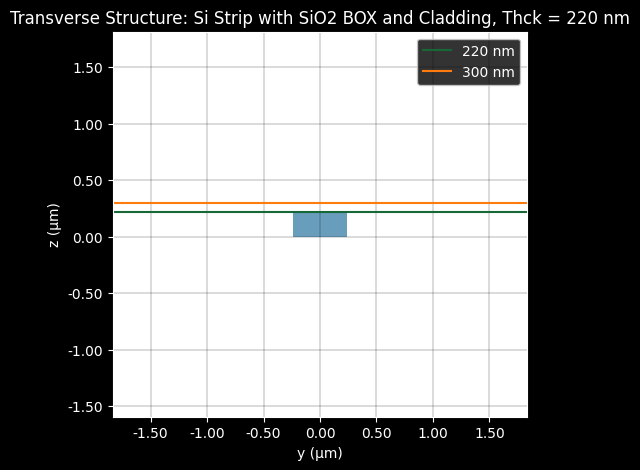

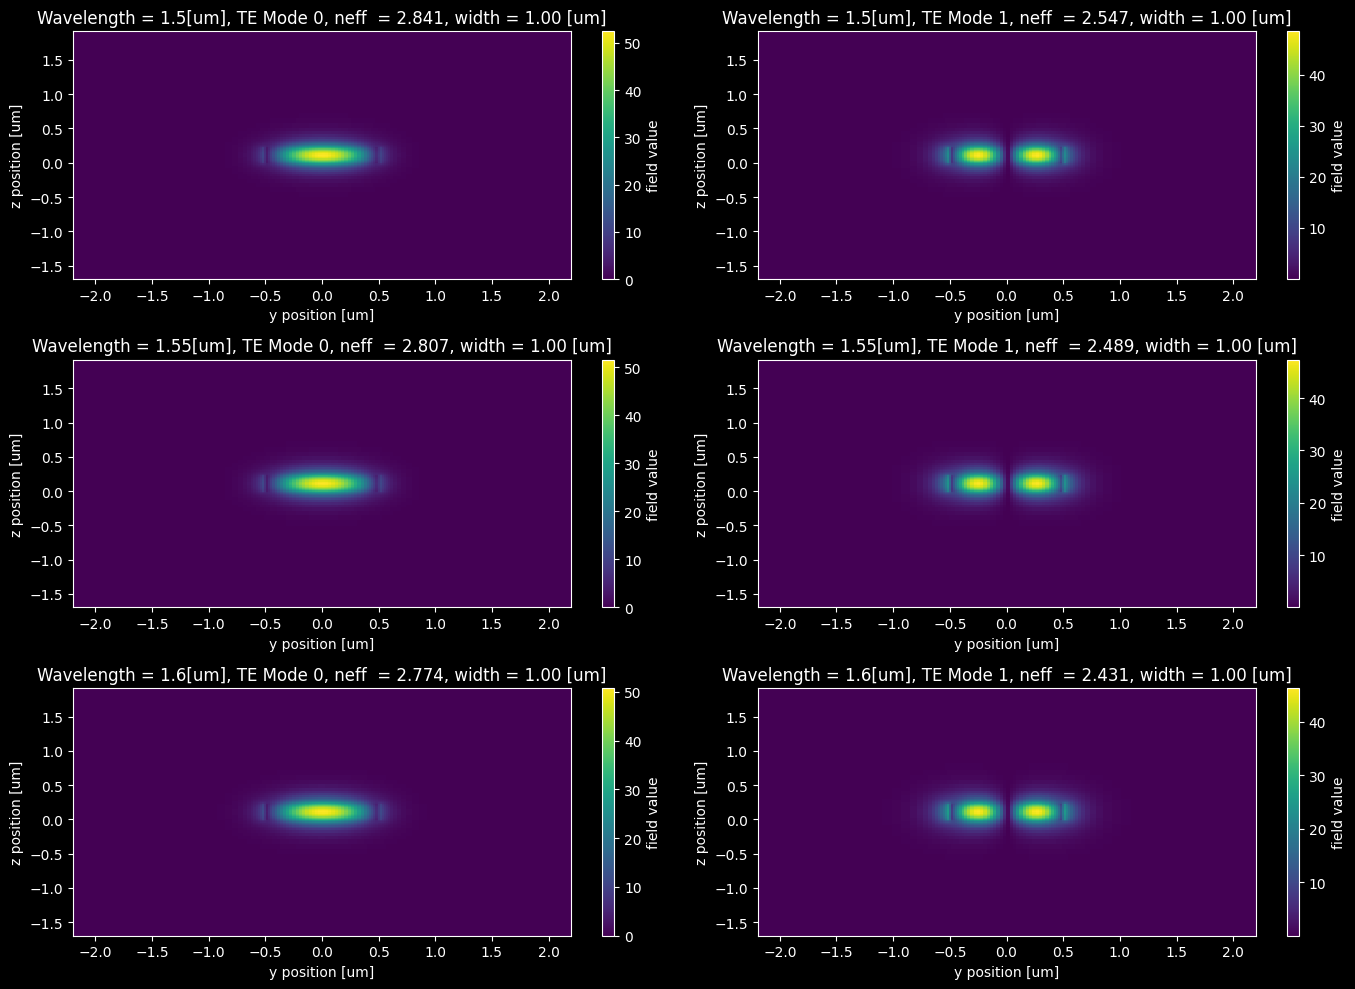

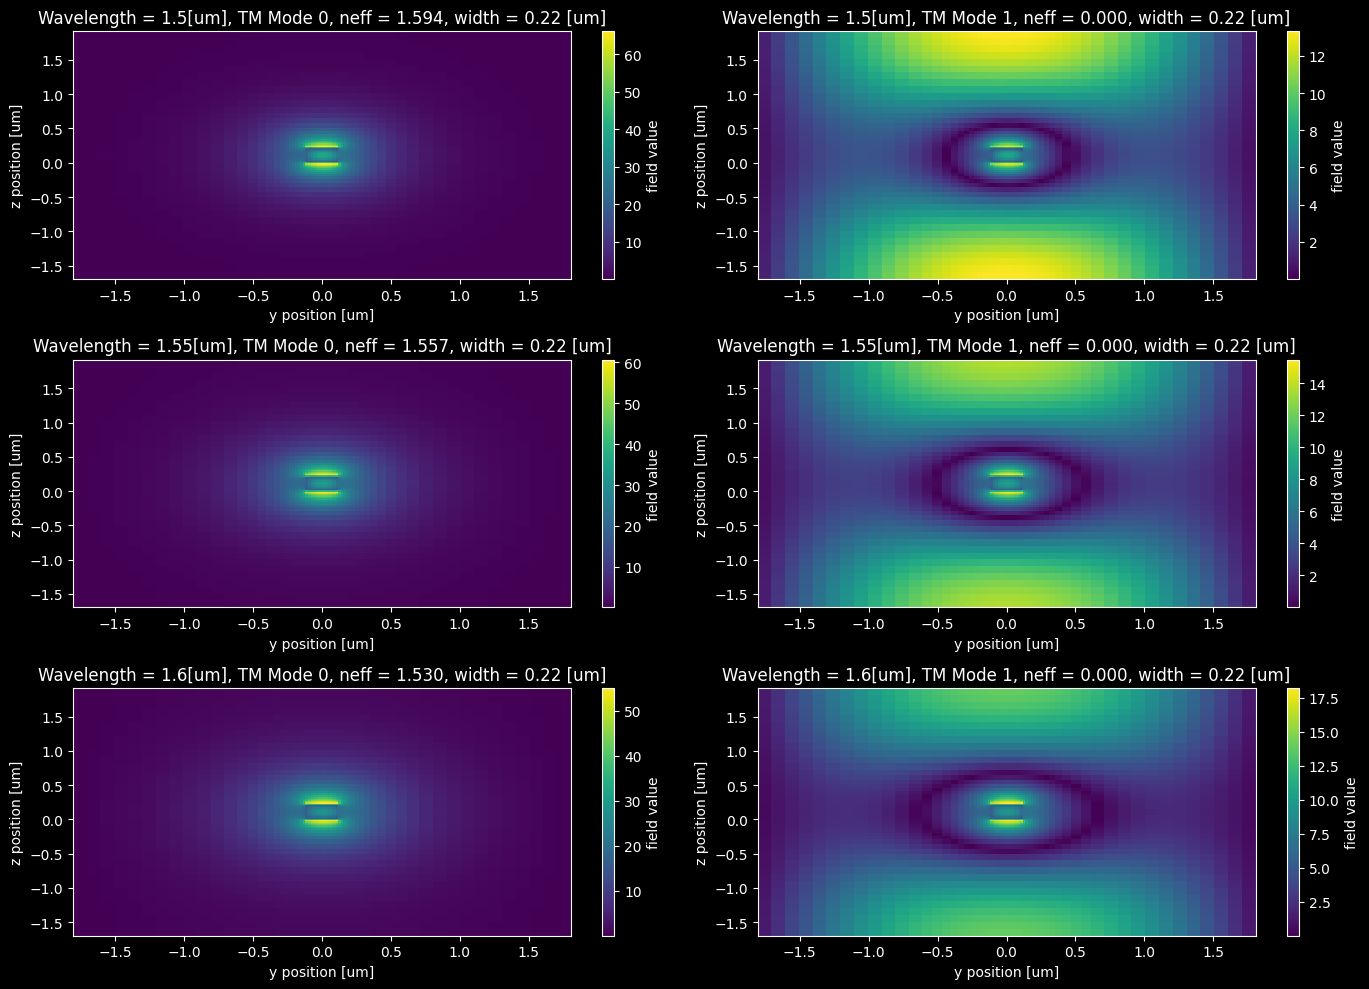

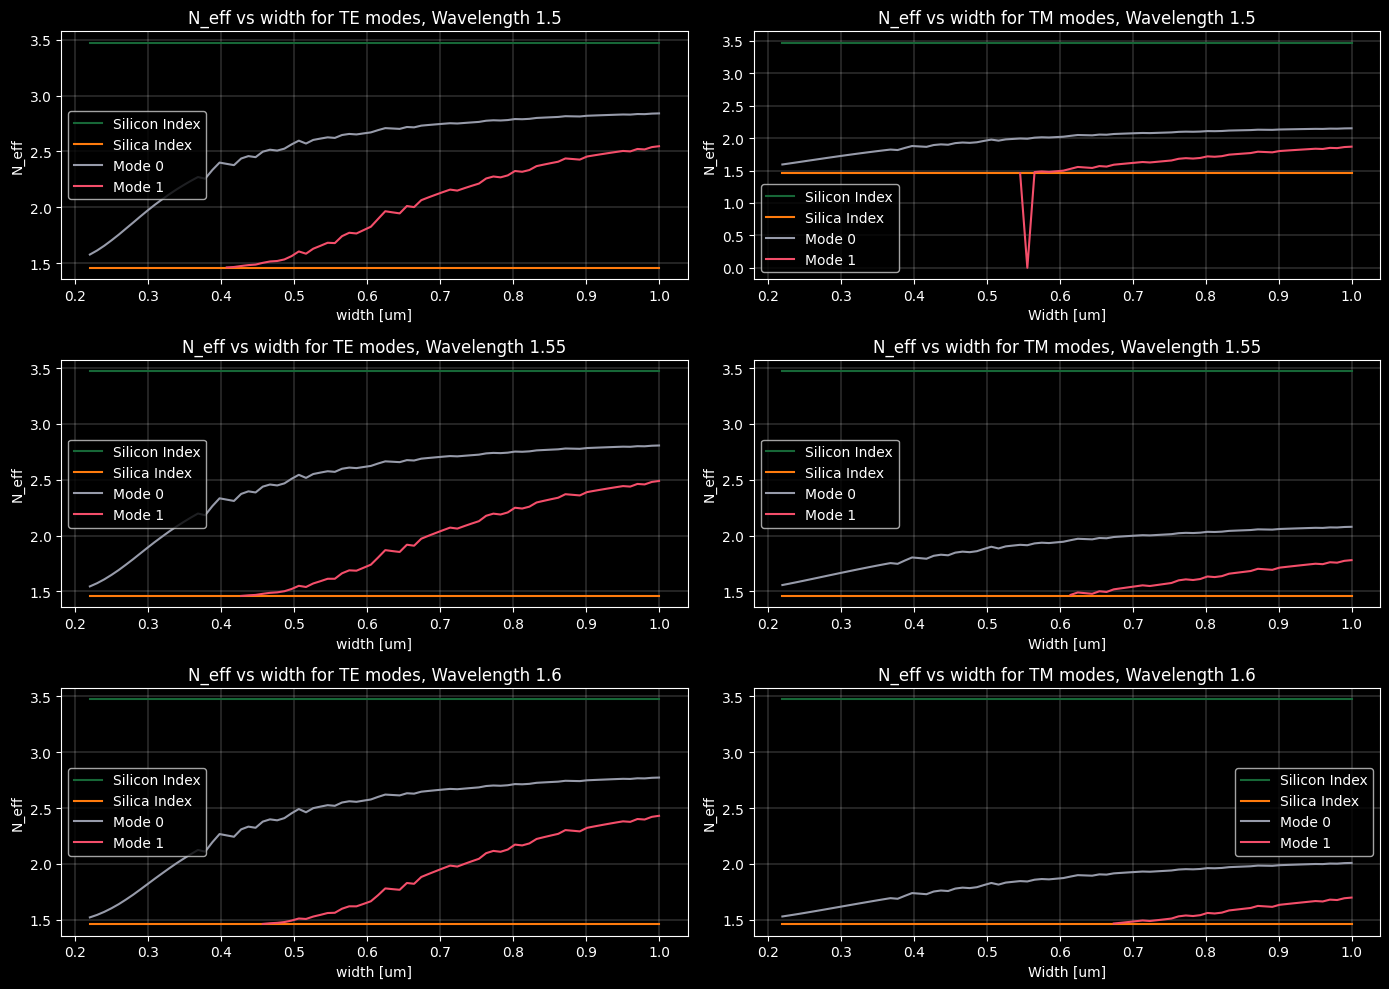

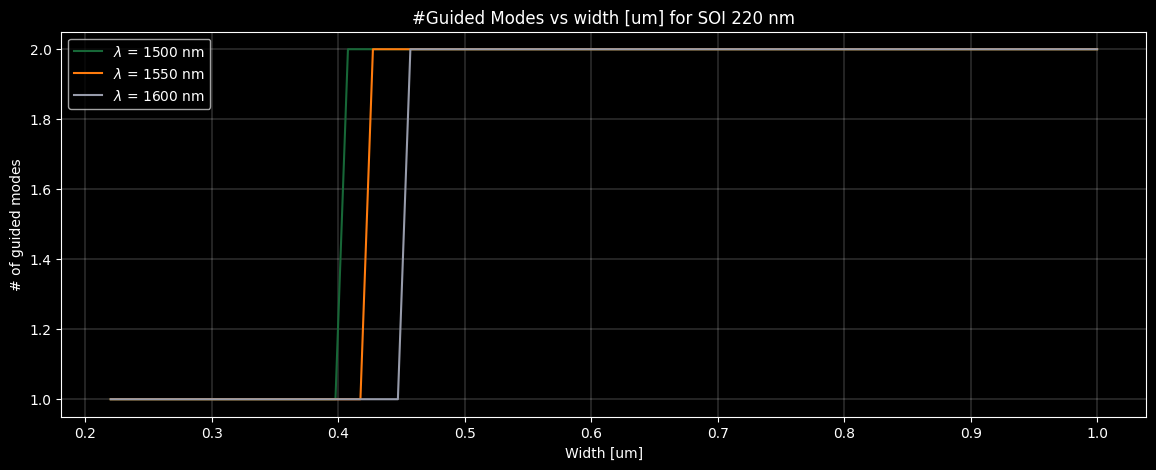

In [94]:
# --- 3. Structure Visualization ---
# We plot the cross-section to verify materials and dimensions
# print(te_neffs_arr)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
strip_waveguide.plot_structures(x= 0, ax=ax)
plt.plot(np.linspace(-2,2,100), np.ones_like(np.linspace(-2,2,100))*0.22, label = "220 nm")
plt.plot(np.linspace(-2,2,100), np.ones_like(np.linspace(-2,2,100))*0.3,  label = "300 nm")
plt.legend()
plt.title("Transverse Structure: Si Strip with SiO2 BOX and Cladding, Thck = 220 nm")
plt.grid(linewidth = 0.2, color = 'black')
plt.show()



# --- 4. Plotting Results for TE Light ---


# Mode index 0 is typically the fundamental Quasi-TE mode
fig1, axs = plt.subplots(wv_points, num_modes, figsize=(14, 10))
# Plot Ey field (dominant component for TE in this orientation)
for freq_ind in range(wv_points):
    for modes in range(len(te_neffs_arr[-1,:,freq_ind])):
        te_data_arr[-1].Ey.abs.isel(f = freq_ind ,mode_index = modes).squeeze().plot(ax = axs[freq_ind][modes],x = 'y', y = 'z')
        axs[freq_ind][modes].set_title(f"Wavelength = {sweep_wavelength[freq_ind]}[um], TE Mode {modes}, neff  = {te_neffs_arr[-1,modes,freq_ind]:.3f}, width = {sweep_width[-1]:.2f} [um]")

plt.tight_layout()
plt.show()



# --- 5. Plotting Results for TM Light ---


# Mode index 0 is typically the fundamental Quasi-TM mode
fig2, axs2 = plt.subplots(wv_points, num_modes, figsize=(14, 10))

# Plot Ey field (dominant component for TE in this orientation)
for freq_ind in range(wv_points):
    for modes in range(len(te_neffs_arr[0,:,freq_ind])):
        tm_data_arr[0].Ez.abs.isel(f = freq_ind ,mode_index = modes).squeeze().plot(ax = axs2[freq_ind][modes],x = 'y', y = 'z')
        axs2[freq_ind][modes].set_title(f"Wavelength = {sweep_wavelength[freq_ind]}[um], TM Mode {modes}, neff = {tm_neffs_arr[0,modes,freq_ind]:.3f}, width = {sweep_width[0]:.2f} [um]")


plt.tight_layout()
plt.show()

# --- 7. Plotting results for width sweep---

fig3, ax_results = plt.subplots(wv_points, 2, figsize=(14, 10))



#Then we plot the results , y values n- effective and x values the widths in microns
for wv_idx,wavelength in enumerate(sweep_wavelength):
    neff_cols_te = extract_nonzero_columns(te_neffs_arr[:,:,wv_idx])
    neff_cols_tm = extract_nonzero_columns(tm_neffs_arr[:,:,wv_idx])
    ax_results[wv_idx][0].plot(sweep_width,np.ones(wdth_points)*n_si, label = "Silicon Index" )
    ax_results[wv_idx][0].plot(sweep_width,np.ones(wdth_points)*n_sio2, label = "Silica Index")

    ax_results[wv_idx][1].plot(sweep_width,np.ones(wdth_points)*n_si, label = "Silicon Index" )
    ax_results[wv_idx][1].plot(sweep_width,np.ones(wdth_points)*n_sio2, label = "Silica Index")

    for (neff_ind, values_neff_te), (_, values_neff_tm) in zip(enumerate(neff_cols_te),enumerate(neff_cols_tm)):
        ax_results[wv_idx][0].plot(sweep_width[wdth_points-len(values_neff_te)::], values_neff_te, label= f"Mode {neff_ind}")

        ax_results[wv_idx][1].plot(sweep_width[wdth_points-len(values_neff_tm)::], values_neff_tm, label= f"Mode {neff_ind}")


        ax_results[wv_idx][0].grid(True,linewidth = 0.2)
        ax_results[wv_idx][0].set_title(f"N_eff vs width for TE modes, Wavelength {wavelength}")
        ax_results[wv_idx][0].set_ylabel("N_eff")
        ax_results[wv_idx][0].set_xlabel("width [um]")


        ax_results[wv_idx][1].grid(True, linewidth = 0.2)
        ax_results[wv_idx][1].set_title(f"N_eff vs width for TM modes, Wavelength {wavelength}")
        ax_results[wv_idx][1].set_ylabel("N_eff")
        ax_results[wv_idx][1].set_xlabel("Width [um]")

    ax_results[wv_idx][0].legend()
    ax_results[wv_idx][1].legend()
plt.tight_layout()


# Finally the number of modes vs width

fig4 , ax4 = plt.subplots(1, 1, figsize=(14, 5))
ax4.plot(sweep_width, count_nonzero_per_row(te_neffs_arr[:,:,0]),label = r"$\lambda$ = 1500 nm")
ax4.plot(sweep_width, count_nonzero_per_row(te_neffs_arr[:,:,1]),label = r"$\lambda$ = 1550 nm")
ax4.plot(sweep_width, count_nonzero_per_row(te_neffs_arr[:,:,2]),label = r"$\lambda$ = 1600 nm")
ax4.set_title("#Guided Modes vs width [um] for SOI 220 nm")
ax4.set_xlabel("Width [um]")
ax4.set_ylabel("# of guided modes")
ax4.grid(True, linewidth = 0.2)
ax4.legend()


## RESULTS FOR 220 nm

For the last graphs is ploted the number of modes including those that are not modes allowed (the ones labeled by neff = 0.0) for one of the widths used to sweep. For TE modes above we plotted for 280 nm width and for TM modes 220 nm width. resulting 2 modes and 1 mode respectively for each geometry structure.

Additionally a plot Neff vs width using a sweep of 100 points for different wavelengths, 1.5, 1.55 and 1.6 um we can see using this plots the tendency of creation of a second mode by a width of arround 400 nm, to be more accurate we will count the number of modes vs width and look up at the cut of, for more points but it will increase the simulation time. For our purposes, having a strip waveguide $\approx$ 400, 420 and 450 nm maximum for each wavelength, the waveguide will contain single mode regime.

With this approach we can obtain single mode regime for proper fabrication constrains, but we can do better to save material and costs.

Minimun transversal area of approximately: 220x400 $nm^{2}$ =88000 $nm^{2}$

# -------------------------------------------------------------------------------------------------------------------------------------


## MODE ANALYSIS FOR SOI 300 nm

Next, we perfom mode analysis, the same as just done above for 300 nm thickness strip waveguide, to look at the cutoff width where aproximately we obtain single mode nature.



In [95]:


# --- 2. Execution ---


# Here we apply the defined function to obtain TE and TM modes separated and kept in te_neff as refractive effective index, and TE data kept on TE data
# Likewise with TM modes
strip_waveguide ,_, _ = get_guided_modes('TE', thickness=0.3)
te_neffs_arr,te_data_arr,tm_neffs_arr,tm_data_arr = (np.zeros((wdth_points,num_modes,wv_points)),
                                                     [],
                                                     np.zeros((wdth_points,num_modes,wv_points)),
                                                     [])

for wdth_idx,w in enumerate(sweep_width):
    _ ,te_neffs, te_data = get_guided_modes('TE', thickness=0.3, width = w, wavelength=sweep_wavelength)
    _,tm_neffs, tm_data = get_guided_modes('TM', thickness=0.3, width = w,  wavelength=sweep_wavelength)

    te_neffs_arr[wdth_idx,:,:] = te_neffs.T
    te_data_arr.append(te_data)
    tm_neffs_arr[wdth_idx,:,:] = tm_neffs.T
    tm_data_arr.append(tm_data)



/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:41:42 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:41:43 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:41:46 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:41:48 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:41:51 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:41:53 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:41:56 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:41:58 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:42:01 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:42:04 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:42:07 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:42:10 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:42:14 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:42:18 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:42:23 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:42:28 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:42:32 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:42:35 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:42:39 -05 WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:42:43 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:42:47 -05 WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:42:51 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:42:55 -05 WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:42:59 -05 WARNING: Mode field at frequency index 0, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:43:03 -05 WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


15:43:07 -05 WARNING: Mode '1' appears to undergo a discontinuous change between
             frequencies '199861638666666.66' and '193414489032258.06' (overlap:
             '0.04').                                                           

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:43:14 -05 WARNING: Mode '1' appears to undergo a discontinuous change between
             frequencies '199861638666666.66' and '193414489032258.06' (overlap:
             '0.01').                                                           

15:43:15 -05 WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:43:23 -05 WARNING: Mode '1' appears to undergo a discontinuous change between
             frequencies '199861638666666.66' and '193414489032258.06' (overlap:
             '0.03').                                                           

             WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:43:30 -05 WARNING: Mode '1' appears to undergo a discontinuous change between
             frequencies '187370286250000.0' and '193414489032258.06' (overlap: 
             '0.02').                                                           

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:43:39 -05 WARNING: Mode '1' appears to undergo a discontinuous change between
             frequencies '199861638666666.66' and '193414489032258.06' (overlap:
             '0.00').                                                           

15:43:40 -05 WARNING: Mode field at frequency index 1, mode index 1 does not    
             decay at the plane boundaries.                                     

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

15:43:47 -05 WARNING: Mode '1' appears to undergo a discontinuous change between
             frequencies '187370286250000.0' and '193414489032258.06' (overlap: 
             '0.57').                                                           

             WARNING: Mode field at frequency index 2, mode index 1 does not    
             decay at the plane boundaries.                                     

/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)
/home/juanes/Desktop/Github/GDS_py_TDY_venv/venv/lib/python3.11/site-packages/scipy/sparse/_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set t

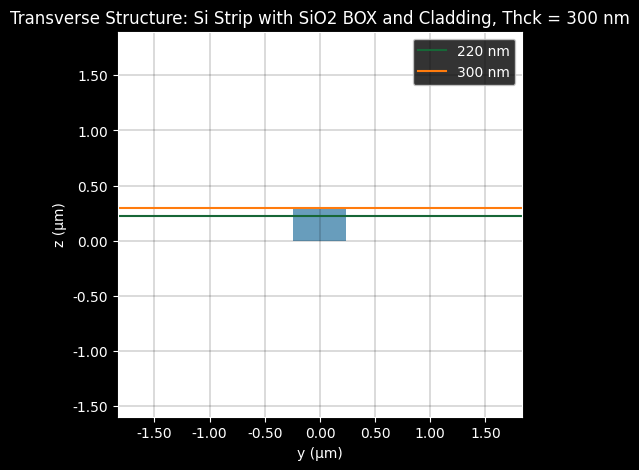

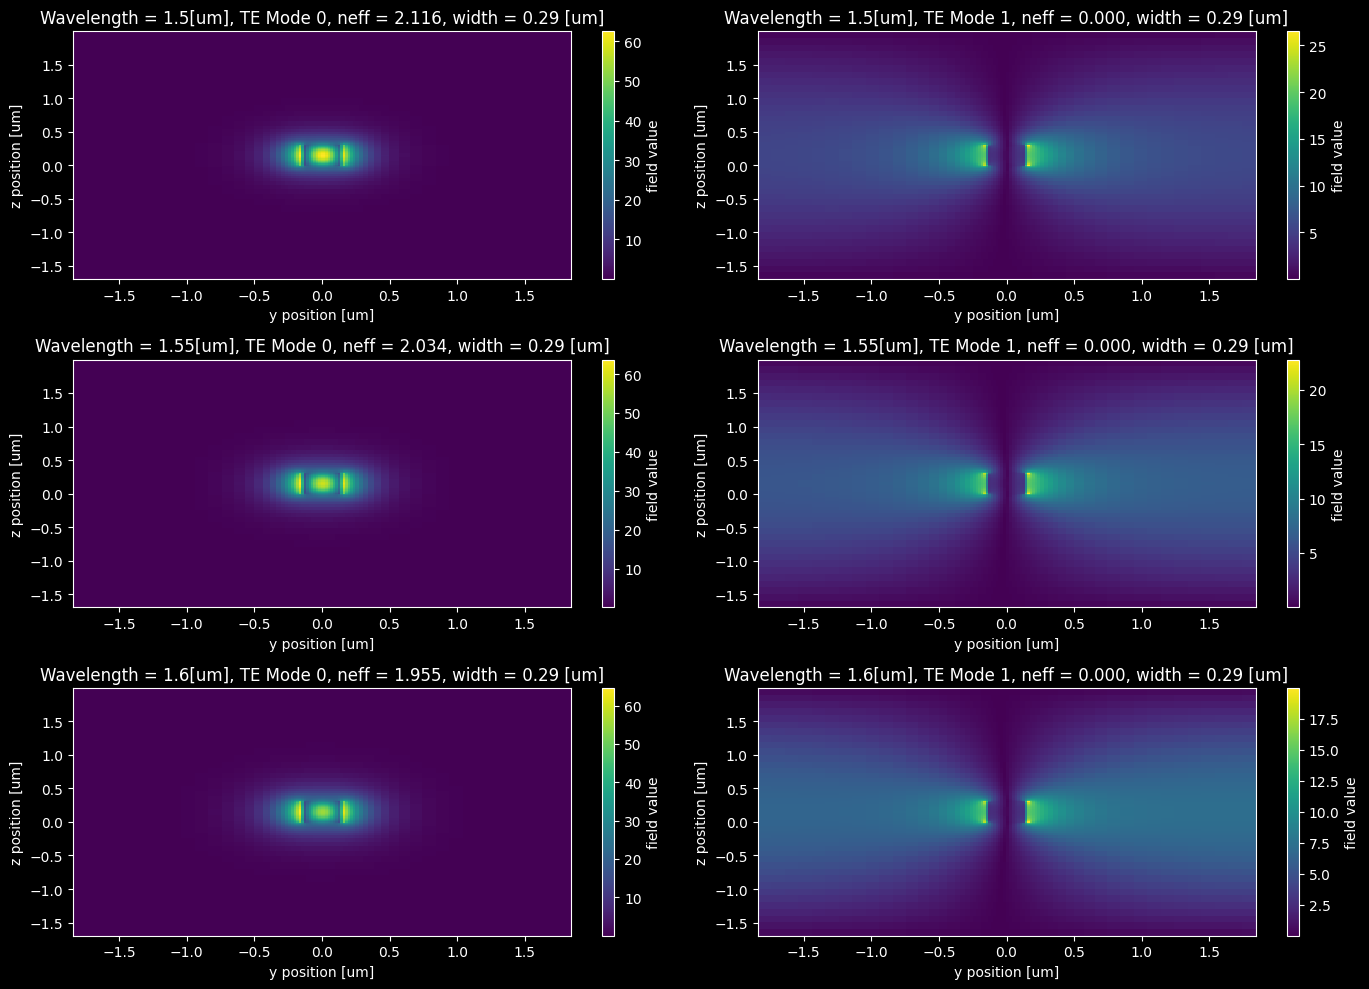

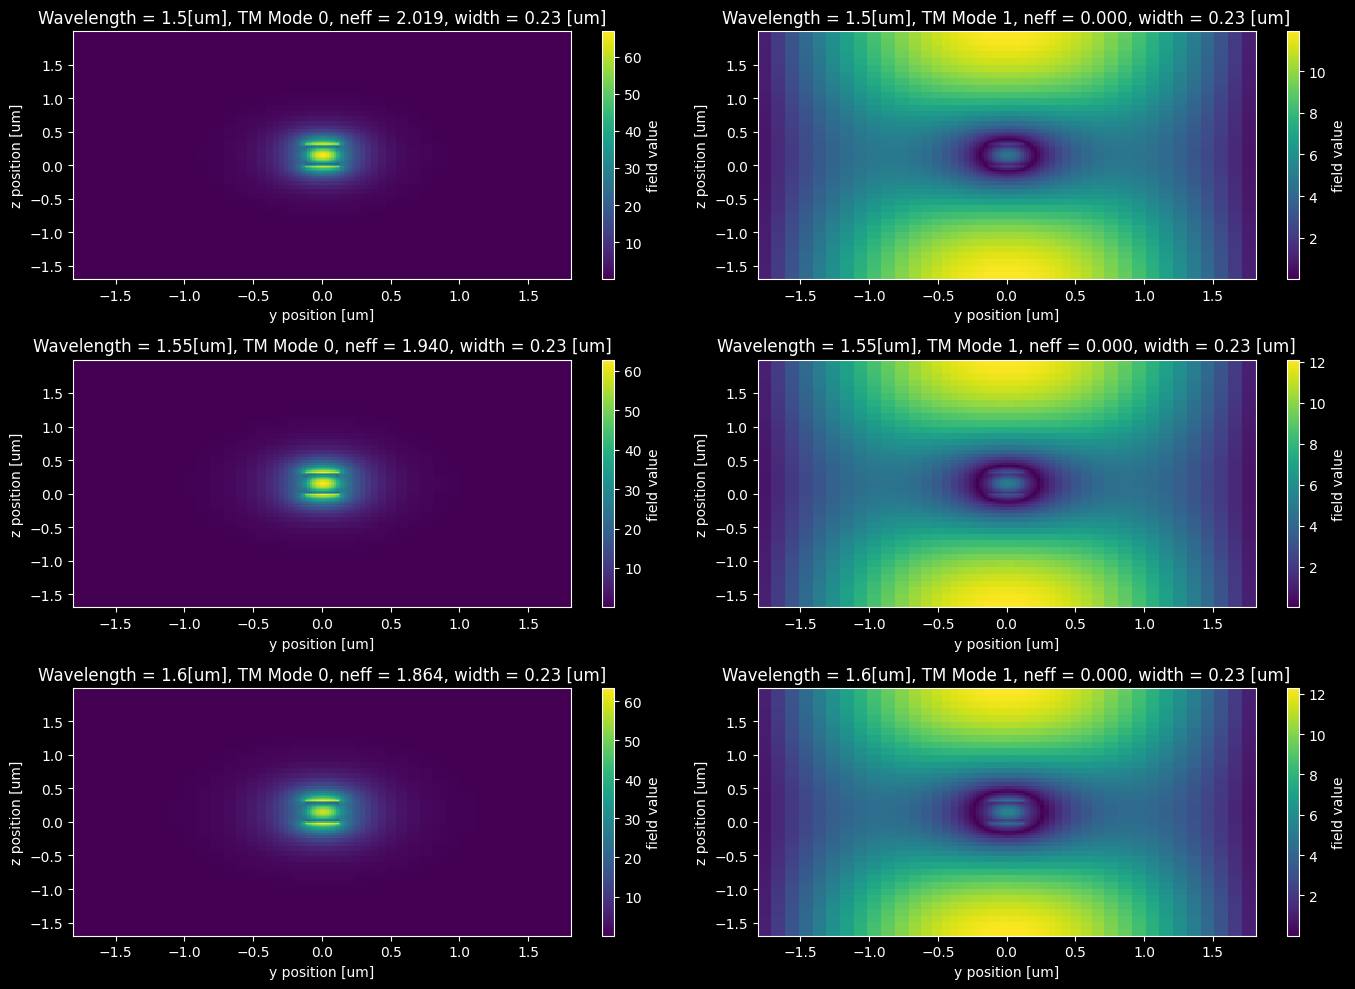

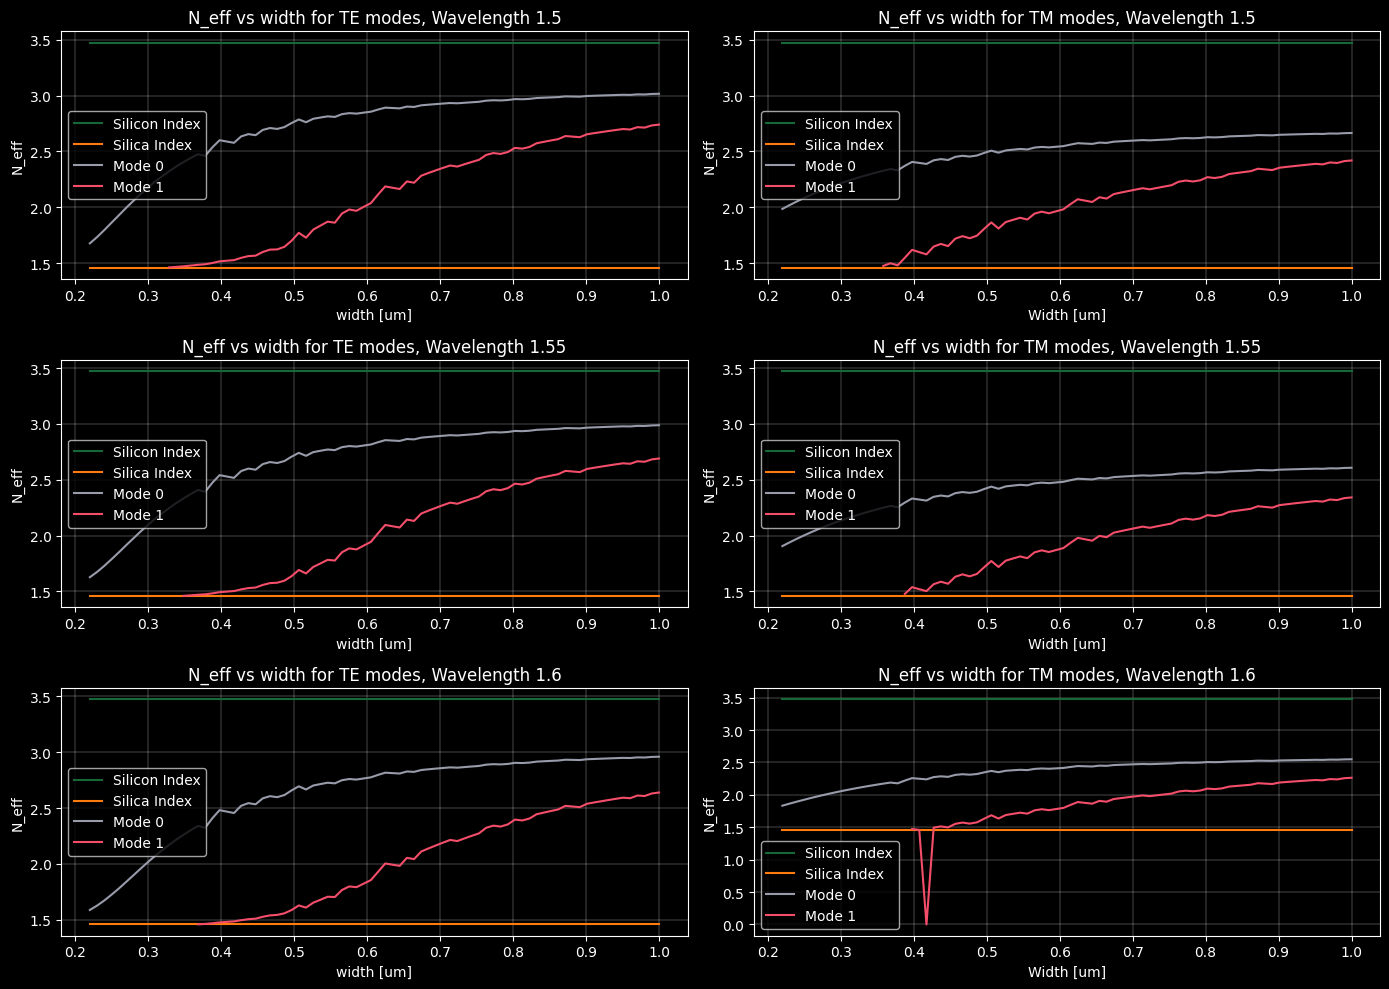

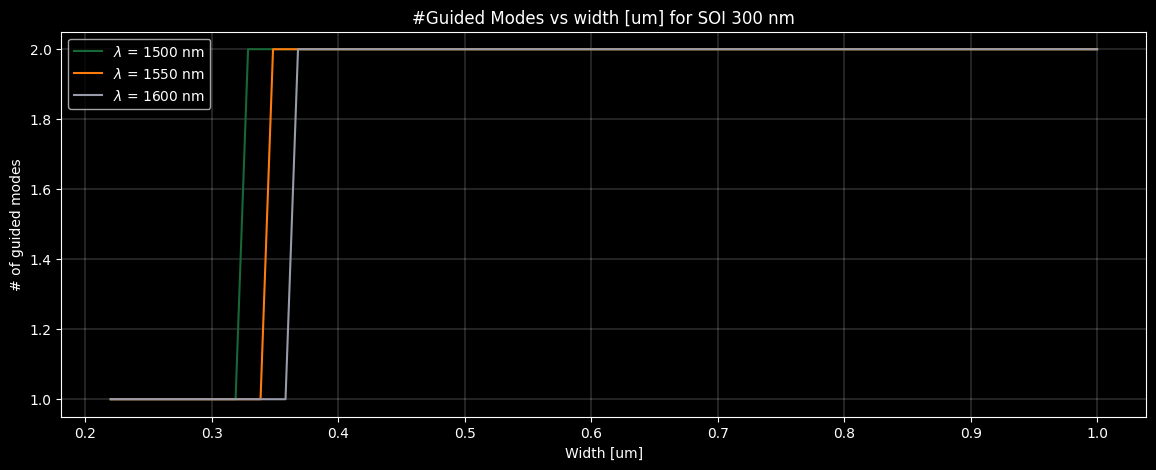

In [96]:
# --- 3. Structure Visualization ---
# We plot the cross-section to verify materials and dimensions
# print(te_neffs_arr)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
strip_waveguide.plot_structures(x= 0, ax=ax)
plt.title("Transverse Structure: Si Strip with SiO2 BOX and Cladding, Thck = 300 nm")
plt.plot(np.linspace(-2,2,100), np.ones_like(np.linspace(-2,2,100))*0.22, label = "220 nm")
plt.plot(np.linspace(-2,2,100), np.ones_like(np.linspace(-2,2,100))*0.3,  label = "300 nm")
plt.legend()
plt.grid(linewidth = 0.2, color = 'black')
plt.show()



# --- 5. Plotting Results for TE Light ---


# Mode index 0 is typically the fundamental Quasi-TE mode
fig1, axs = plt.subplots(wv_points, num_modes, figsize=(14, 10))
# Plot Ey field (dominant component for TE in this orientation)
for freq_ind in range(wv_points):
    for modes in range(len(te_neffs_arr[7,:,freq_ind])):
        te_data_arr[7].Ey.abs.isel(f = freq_ind ,mode_index = modes).squeeze().plot(ax = axs[freq_ind][modes],x = 'y', y = 'z')
        axs[freq_ind][modes].set_title(f"Wavelength = {sweep_wavelength[freq_ind]}[um], TE Mode {modes}, neff = {te_neffs_arr[7,modes,freq_ind]:.3f}, width = {sweep_width[7]:.2f} [um]")

plt.tight_layout()
plt.show()



# --- 6. Plotting Results for TM Light ---


# Mode index 0 is typically the fundamental Quasi-TM mode
fig2, axs2 = plt.subplots(wv_points, num_modes, figsize=(14, 10))

# Plot Ey field (dominant component for TE in this orientation)
for freq_ind in range(wv_points):
    for modes in range(len(te_neffs_arr[1,:,freq_ind])):
        tm_data_arr[1].Ez.abs.isel(f = freq_ind ,mode_index = modes).squeeze().plot(ax = axs2[freq_ind][modes],x = 'y', y = 'z')
        axs2[freq_ind][modes].set_title(f"Wavelength = {sweep_wavelength[freq_ind]}[um], TM Mode {modes}, neff = {tm_neffs_arr[1,modes,freq_ind]:.3f}, width = {sweep_width[1]:.2f} [um]")


plt.tight_layout()
plt.show()

# --- 7. Plotting results for width sweep---

fig3, ax_results = plt.subplots(wv_points, 2, figsize=(14, 10 ))


#Then we plot the results , y values n- effective and x values the widths


for wv_idx,wavelength in enumerate(sweep_wavelength):
    neff_cols_te = extract_nonzero_columns(te_neffs_arr[:,:,wv_idx])
    neff_cols_tm = extract_nonzero_columns(tm_neffs_arr[:,:,wv_idx])
    ax_results[wv_idx][0].plot(sweep_width,np.ones(wdth_points)*n_si, label = "Silicon Index" )
    ax_results[wv_idx][0].plot(sweep_width,np.ones(wdth_points)*n_sio2, label = "Silica Index")

    ax_results[wv_idx][1].plot(sweep_width,np.ones(wdth_points)*n_si, label = "Silicon Index" )
    ax_results[wv_idx][1].plot(sweep_width,np.ones(wdth_points)*n_sio2, label = "Silica Index")

    for (neff_ind, values_neff_te), (_, values_neff_tm) in zip(enumerate(neff_cols_te),enumerate(neff_cols_tm)):
        ax_results[wv_idx][0].plot(sweep_width[wdth_points-len(values_neff_te)::], values_neff_te, label= f"Mode {neff_ind}")

        ax_results[wv_idx][1].plot(sweep_width[wdth_points-len(values_neff_tm)::], values_neff_tm, label= f"Mode {neff_ind}")


        ax_results[wv_idx][0].grid(True,linewidth = 0.2)
        ax_results[wv_idx][0].set_title(f"N_eff vs width for TE modes, Wavelength {wavelength}")
        ax_results[wv_idx][0].set_ylabel("N_eff")
        ax_results[wv_idx][0].set_xlabel("width [um]")


        ax_results[wv_idx][1].grid(True, linewidth = 0.2)
        ax_results[wv_idx][1].set_title(f"N_eff vs width for TM modes, Wavelength {wavelength}")
        ax_results[wv_idx][1].set_ylabel("N_eff")
        ax_results[wv_idx][1].set_xlabel("Width [um]")

    ax_results[wv_idx][0].legend()
    ax_results[wv_idx][1].legend()
plt.tight_layout()



# Finally the number of modes vs width

fig5 , ax5 = plt.subplots(1, 1, figsize=(14, 5))
ax5.plot(sweep_width, count_nonzero_per_row(te_neffs_arr[:,:,0]),label = r"$\lambda$ = 1500 nm")
ax5.plot(sweep_width, count_nonzero_per_row(te_neffs_arr[:,:,1]),label = r"$\lambda$ = 1550 nm")
ax5.plot(sweep_width, count_nonzero_per_row(te_neffs_arr[:,:,2]),label = r"$\lambda$ = 1600 nm")
ax5.set_title("#Guided Modes vs width [um] for SOI 300 nm")
ax5.set_xlabel("Width [um]")
ax5.set_ylabel("# of guided modes")
ax5.grid(True, linewidth = 0.2)
ax5.legend()
plt.show()

## RESULTS FOR 300 nm

For the last graphs is ploted the number of modes including those that are not modes allowed (the ones labeled by neff = 0.0) for one of the widths used to sweep. For TE modes above we plotted for 740 nm width and for TM modes 300 nm width, resulting 2 modes and 1 mode respectively for each geometry structure aforementioned.

Additionally a plot Neff vs width using a sweep of 100 points for different wavelengths, 1.5, 1.55 and 1.6 um we can see using this plots the tendency of creation of a second mode by a width of arround 400 nm; to be more accurate we will count the number of modes vs width and look up at the cutoff, more points will increase the simulation time. For our purposes, having a strip waveguide $\approx$ 400, 420 and 450 nm maximum for each wavelength, the waveguide will contain single mode regime.

With this approach we can obtain single mode regime for proper fabrication constrains, at the end, the best option will be the one that uses the less amount of material. for this case:

Minimum transversal area: 300x320 $nm^{2}$ = 96000 $nm^{2}$

As a conclusion, we can perform the same results of single mode regime with 220 nm thickness due to savings of material.
# -------------------------------------------------------------------------------------------------------------------------------------